# Skillfactory - Практический Machine Learning

Композиции алгоритмов

#  Композиции алгоритмов
aka 
* Ансамбли моделей
* Комитеты алгоритмов

## Bagging и Случайный лес (Random Forest)

Дерево решений очень чувствительно к данным

In [1]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd

In [2]:
from sklearn.datasets import make_moons

def demo_2dec_tree():
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)

    np.random.seed(0)
    
    X, y = make_moons(noise=0.3, random_state=42)
    
    # Dec Tree Stuff
    for i in range(2):
        idx = np.random.randint(0, X.shape[0], int(0.95*X.shape[0]))

        X1 = X[idx, :]
        y1 = y[idx]

        ax[i].scatter(X1[:,0], X1[:, 1], c=y1)
        ax[i].set_xlabel('$x_1$')
        ax[i].set_ylabel('$x_2$')

        # Dec Tree Stuff 2
        tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)
        tree.fit(X1,y1)

        x_range = np.linspace(X.min(), X.max(), 100)
        xx1, xx2 = np.meshgrid(x_range, x_range)

        Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
        Y = Y.reshape(xx1.shape)

        ax[i].contourf(xx1, xx2, Y, alpha=0.3)
        ax[i].scatter(X[:,0], X[:,1],c=y)

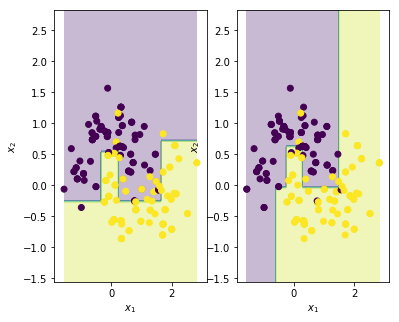

In [3]:
demo_2dec_tree()

Bagging - это **параллельный** способ построения ансамбля.<br/>
1. Обучающая выборка сэмплируется $k$ раз с помощью *bootstrap'a* (выборка с возвратом)
2. На каждом сэмпле обучается отдельная **базовая модель**
3. Ответы моделей усредняются (возможно с весом)
<center><img src='http://image.slidesharecdn.com/ipbimprovingthemodelspredictivepowerwithensembleapproaches-121203224610-phpapp02/95/improving-the-models-predictive-power-with-ensemble-approaches-10-638.jpg?cb=1354575467' width='750'></center>

Так же есть некоторые обобщения бэггинга:

* Метод случайных подпространств - на шаге 1. сэмплируются не только объекты, но и подпространство признаков
* Метод случайного леса - на каждом узле сэмплируется подпространство признаков

В данном случае, на каждом сэмпле базовой моделью является дерево решений.<br/>
Если вам нужно за минимальное время построить достаточно точную и устойчивую модель - это ваш вариант.


<center><img src='img/rf-quote.png'></center>

In [4]:
from sklearn.ensemble import RandomForestClassifier

def rf_demo(n_est=5):
    rf = RandomForestClassifier(random_state=123, n_estimators=n_est)

    np.random.seed(0)
    
    X, y = make_moons(noise=0.3, random_state=123)
    rf.fit(X, y)
    
    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)
    
    
    for tree in rf.estimators_:
        y_hat = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
        y_hat = y_hat.reshape(xx1.shape)

        plt.contourf(xx1, xx2, y_hat, alpha=1.0/n_est)
    plt.scatter(X[:,0], X[:,1], c=y)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.title('N estimators = %d' % n_est)
    plt.show()


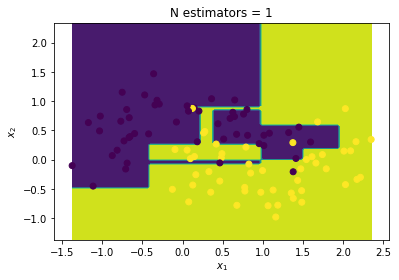

In [5]:
fig = interact(rf_demo, n_est=IntSlider(min=1, max=101, value=1, step=5))

## Данные об оттоке из игры

In [6]:
dfx = pd.read_csv('data/x_train.csv', sep=';')
dfy = pd.read_csv('data/y_train.csv', names=['target'])


In [7]:
X = dfx.values
y = dfy.values.flatten()

In [29]:
dfx.head().T

,0,1,2,3,4
maxPlayerLevel,3.900000e+01,2.100000e+01,5.0,21.0,4.0
numberOfAttemptedLevels,1.000000e+01,2.200000e+01,6.0,2.0,5.0
attemptsOnTheHighestLevel,3.000000e+00,1.900000e+01,1.0,5.0,1.0
totalNumOfAttempts,1.700000e+01,5.500000e+01,6.0,6.0,5.0
averageNumOfTurnsPerCompletedLevel,2.444444e+01,1.704545e+01,8.4,19.0,9.6
doReturnOnLowerLevels,1.000000e+00,1.000000e+00,0.0,0.0,0.0
numberOfBoostersUsed,5.000000e+00,6.000000e+00,1.0,1.0,1.0
fractionOfUsefullBoosters,4.000000e-01,3.333333e-01,1.0,0.0,1.0
totalScore,2.650000e+06,5.614000e+06,857000.0,120000.0,857000.0
totalBonusScore,1.375000e+03,3.825000e+03,1150.0,0.0,1075.0


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

### Качество на одном дереве

In [9]:
cv = StratifiedKFold(n_splits=4, random_state=123)
scoring = 'roc_auc'

In [10]:
model = DecisionTreeClassifier()

In [11]:
depths = range(1, 10)
_, tree_test_scores = validation_curve(model, X, y, param_name='max_depth', param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=-1)

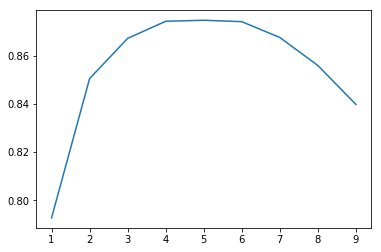

In [12]:
plt.plot(depths, tree_test_scores.mean(axis=1))

### Бэггинг над деревьями

In [13]:
from sklearn.ensemble import BaggingClassifier

In [14]:
model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, random_state=123)

In [15]:
_, bag_test_scores = validation_curve(model, X, y, param_name='base_estimator__max_depth', param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=-1)

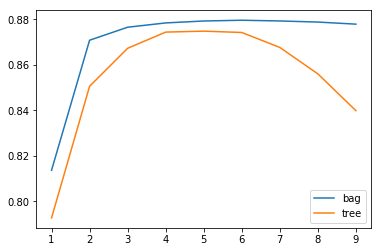

In [16]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.legend()

### Случайных лес

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
model = RandomForestClassifier(random_state=123, n_estimators=50, n_jobs=-1)

In [19]:
_, forest_test_scores = validation_curve(model, X, y, param_name='max_depth', param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=1)

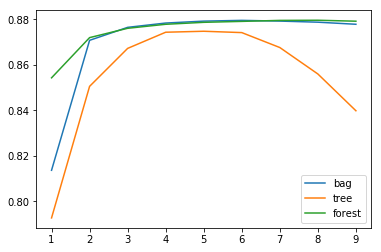

In [20]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_test_scores.mean(axis=1), label='forest')
plt.legend()

## Разные фишки

### Бэггинг можно делать не только над деревьями

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [22]:
cv = StratifiedKFold(n_splits=4, random_state=123)
scoring = 'roc_auc'

In [30]:
scores = []
n_est =  [1, 10, 20, 50, 100]

base_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ])

for n in n_est:
    model = BaggingClassifier(base_estimator=base_model, 
                              n_estimators=n, 
                              bootstrap_features=False, n_jobs=1)
    scores.append(cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1).mean())

In [31]:
scores

[0.8744921169826364,
 0.8735916629319462,
 0.8737858865855154,
 0.8736589648980716,
 0.8737304074518384]

### Листья деревьев как признаки!

Перед тем как применять линейную модель, можно собрать специальные признаки на основе деревьев.

* Предварительно на данных строим лес из $T$ деревьем
* Нумеруем листья каждого дерева от $0$ до $L_T$
* Для каждого дерева собираем новый признак "номер листа в котором оказался объект"
* Прогоняем новые признаки через OHE 
* Profit?

Можно строить такое признаковое пространство с помощью случайного леса, но надо быть осторожным!

Можно строить случайные деревья!

In [32]:
from sklearn.ensemble import RandomTreesEmbedding

In [46]:
emb = RandomTreesEmbedding(n_estimators=10, max_depth=5, random_state=123)
emb.fit(X)

# emb = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=123)
# emb.fit(X, y)

RandomTreesEmbedding(max_depth=5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=123, sparse_output=True, verbose=0,
           warm_start=False)

In [47]:
X_emb = emb.apply(X)

In [48]:
X_emb[:10]

array([[15, 15, 12, 31,  5,  5,  6,  5, 15, 18],
       [23, 15, 15, 31,  5, 23,  6,  5, 15, 39],
       [15,  5,  9, 31,  8,  5,  5, 41,  8,  6],
       [ 8,  5, 12,  5,  5,  5,  5,  5,  5,  5],
       [15,  5,  8, 31,  8,  5,  5, 41,  8,  6],
       [ 5,  5,  5, 12,  5,  5,  5,  5,  5,  5],
       [15,  5, 12, 31,  9,  5,  6,  5,  8, 18],
       [15,  5, 12, 31,  5,  5,  6,  5,  5, 18],
       [ 8,  5,  5, 30,  5,  5,  5,  5,  5,  5],
       [ 5, 12,  6, 30,  5,  5,  5,  5, 12,  5]])

In [49]:
X_emb_sparse = emb.transform(X)

In [50]:
X_emb_sparse

<25289x224 sparse matrix of type '<class 'numpy.float64'>'
	with 252890 stored elements in Compressed Sparse Row format>

In [51]:
model = Pipeline([
    ('tree_emb', RandomTreesEmbedding(n_estimators=50, max_depth=4)),
    ('clf', LogisticRegression(C=0.1))
])

simple_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=0.1))
])


In [52]:
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
scores.mean()

0.8763590056853109

In [53]:
scores = cross_val_score(simple_model, X, y, scoring=scoring, cv=cv)
scores.mean()

0.8734718098516357

## Бустинг

Boosting, в отличие от bagging'а - это последовательный способ построения композиции моделей.

Мы постоянно работаем с одним и тем же набором данных, **но** на каждом шаге строим новую базовую модель, которая учитывает ошибки предыдущей модели.<br\>По большому счету, бустинг-алгоритмы отличаются лишь тем, как в них заложен учет этих самых ошибок.

Например в методе **AdaBoost** каждому объекту присваивается вес, который изменяется в зависимости от того, ошиблась ли на нем очередная композиция базовых алгоритмов или нет. Так же веса имеются и у самих базовых моделей, которые штрафуют их за плохие предсказания. Для задачи классификации этот процесс можно проиллюстрировать следующим образом:


<center><img src='https://s9.postimg.org/lq3lethhr/boosting.png' width='850'></center>

### Формальное описание алгоритма AdaBoost

#### Обозначения
Введем следующие обозначения:
* $t_k$ - базовый классификатор, полученный на шаге $k$
* $\alpha_k$ - вес базового классификатора, полученного на шаге $k$
* $w_k(i)$ - веса объектов на шаге $k$
* $x_i$ - $i$-й объект, $i = 1, \dots, N$
* $y_i=\{-1, 1\}$ - метки класса для $i$-го объекта 

#### Конечное предсказание
Конечное предсказание получается из взвешенной комбинации предсказания базовых моделей:
$$ T(x^*) = sign(\sum\limits^{K}_{k=1}\alpha_kt_k(x^*)) $$

Наша цель - минимизировать количество ошибок на всей выборке ..

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] $$

.. которые мы мажорируем экспонентой =)

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] \leq \frac{1}{N}\sum\limits_{i=1}^N e^{(-y_i\sum_k\alpha_kt_k(x_i))} $$

Если мы посчитаем ошибки $E_1, E_2, E_3,...$ на каждом шаге, то это даст нам правило для обновления весов объектов. <br\>
А если мы посчитаем производную ошибки $E_t$ по $\alpha_t$, то это даст нам правило для обновления весов базовых моделей. <br\>

#### Алгоритм
Алгоритм обучения **Discrete AdaBoost**:

* Инициализируем веса объектов $w_1(i) = \frac{1}{N}$ 
* Для $k = 1..K$
    * Обучить классификатор $t_k(x) \in \{-1, 1\}$ используя веса объектов $w(i)_k$
    * Вычислить взвешенную ошибку $\epsilon = \frac{\sum_i w_{k}(i)[y_i \neq t_k(x_i) ]}{\sum_i w_{k}(i)}$
    * Вычислить вес базовой модели $\alpha_k = \ln\frac{1-\epsilon}{\epsilon}$
    * Пересчитать веса объектов $w_{k+1}(i) = \frac{w_{k}(i) e^{-\alpha_k y_i t_k(x_i)}}{W}$, $i = 1, \dots, N$,где $W = \sum_i w_k(i) e^{-\alpha_k y_i t_k(x_i)}$ - нормировочная константа.
* $T(x) = sign(\sum_k \alpha_k t_k(x))$

### Демо

In [54]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X_moons, y_moons)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)

    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
    
    plt.show()

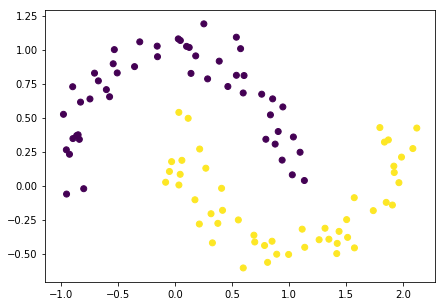

In [55]:
X_moons, y_moons = make_moons(noise=0.1)
plt.figure(figsize=(7,5))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

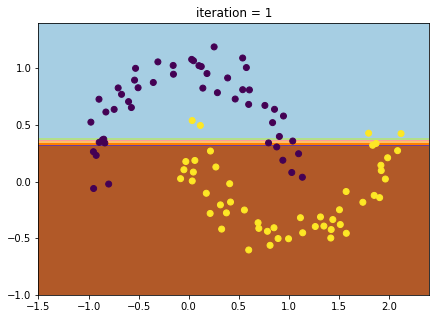

<function __main__.ada_demo(n_est=1)>

In [56]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

### Применим на наших данных

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123, test_size=0.2)

In [59]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                         n_estimators=1000, 
                         learning_rate=0.01, 
                         random_state=123)

In [60]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=1000, random_state=123)

In [61]:
scores_train = []
scores_valid = []

for y_pred in ada.staged_predict_proba(X_train):
    scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
    
for y_pred in ada.staged_predict_proba(X_valid):
    scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1]))

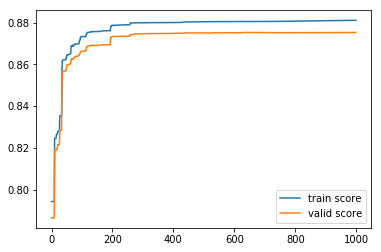

In [62]:
plt.plot(scores_train, label='train score')
plt.plot(scores_valid, label='valid score')
plt.legend()

In [63]:
scores = cross_val_score(ada, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.8785013255852753

## Градиентный бустинг


По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

### Немного формальности

Пусть дана дифференцируемая функция потерь $L(T_k(x), y)$ (для любой задачи - регрессии или классификации) <br\>
Функционал качества - $Q(T, y) = \sum_iL(T_k(x_i), y_i) = \sum_iL(T_{k-1}(x_i) + t_{k}(x_i), y_i)$


На секунду представим, что $t_{k}(x_i)$ - это просто вектор значений (значение для каждого объекта). 

Надо "сдвинуть" ответы предыдущей композиции $T_{k-1}$, так чтобы минимизировать функцию потерь (как в градиентном спуске)

Тогда задачу оптимизации $Q(T, y)$ можно решать простым градиентным методом:

* $T_0$ - начальное приближение
* Посчитаем градиент функции потерь $L$: $g_i = \frac{\partial L(T_{k-1}(x_i), y_i)}{\partial T_{k-1}(x_i)}$, $i = 1, \dots, N$ 
* $T_k = T_{k-1} - \alpha g$ - делаем градиентный шаг


Тогда $t_{k}(x) =  \arg\min\limits_{t} \sum\limits_i(t_{k}(x_i) - g_i)^2$, не зависимо от функции потерь.

### Демо

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

def grad_demo(n_est=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X)/X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    

    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, alpha=0.4, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')
    plt.xlabel('x')
    plt.xlabel('y')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

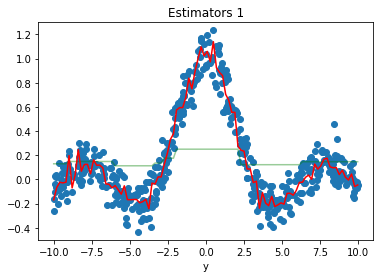

<function __main__.grad_demo(n_est=1)>

In [65]:
interact(grad_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

#### Особенности
* Последовательное обучение
* Склонность к переобучению
* Проблемы с интерпретацией

Наибольший успех, а потому и популярность, получил градиентный бустинг на деревьях решений.

На досуге обратите внимание на модель `xgboost`. Вводный курс по этой модели можно найти [тут](http://education.parrotprediction.teachable.com/p/practical-xgboost-in-python)

Так же есть другая популярная реализация бустинга [LightGBM](https://github.com/Microsoft/LightGBM)

И, конечно же, недавний [CatBoost](https://tech.yandex.ru/catboost/), [видео](https://youtu.be/Q_xa4RvnDcY)

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

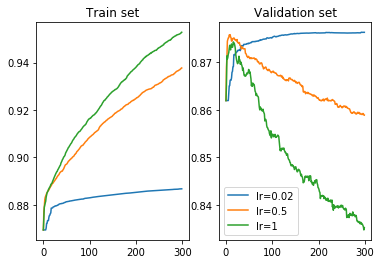

In [67]:
fig, ax = plt.subplots(1,2)

for lr in [0.02, 0.5, 1]:

    model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=lr, 
                                       random_state=123)
    model.fit(X_train, y_train)

    scores_train = []
    scores_valid = []

    for y_pred in model.staged_predict_proba(X_train):
        scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
        
    ax[0].plot(scores_train, label='lr={}'.format(lr))
    ax[0].set_title('Train set')

    for y_pred in model.staged_predict_proba(X_valid):
        scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1])) 
        
    ax[1].plot(scores_valid, label='lr={}'.format(lr))
    ax[1].set_title('Validation set')
plt.legend()


In [68]:
model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=0.02, 
                                       random_state=123)

In [69]:
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.8799078349232687

In [70]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [71]:
imp = pd.Series(index=dfx.columns, data=model.feature_importances_)

In [72]:
imp

maxPlayerLevel                        0.109797
numberOfAttemptedLevels               0.003750
attemptsOnTheHighestLevel             0.048529
totalNumOfAttempts                    0.253958
averageNumOfTurnsPerCompletedLevel    0.110087
doReturnOnLowerLevels                 0.003267
numberOfBoostersUsed                  0.066444
fractionOfUsefullBoosters             0.028718
totalScore                            0.066346
totalBonusScore                       0.021913
totalStarsCount                       0.011624
numberOfDaysActuallyPlayed            0.275568
dtype: float64

### Попытка интерпретации - partial dependency plot

In [73]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


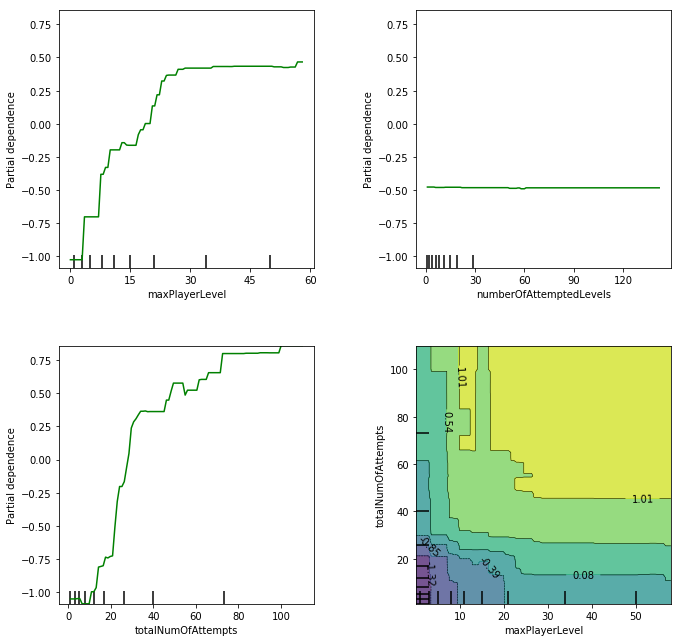

In [78]:
fig, ax =\
plot_partial_dependence(model, X_train, [0, 1, 3, (0,3)], 
                        feature_names=dfx.columns, n_cols=2, verbose=1, figsize=(10,15))

In [79]:
pdp, axes = partial_dependence(model, [0], X=X_train, )

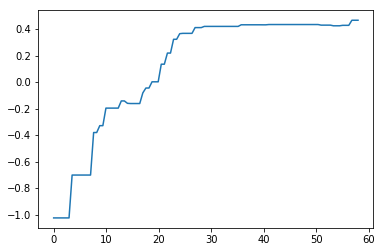

In [80]:
plt.plot(axes[0], pdp[0])

# Стэкинг и Блендинг

Схемы бэггинга и бустинка не гибкие. По сути, на каждом этапе обучается один и тот же алгоритм на немного измененных данных.

Можно еще собирать ансамбли **разных моделей** и аггрегировать их результаты. Только не переобучиться бы..

### Схема классического блендинга
<center><img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking.png?w=700'></center>

### Схема классического стекинга
<center><img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking-2b.png?w=700'></center>

### Стэкинг франкенштейн

<img src='https://kaggle2.blob.core.windows.net/forum-message-attachments/79598/2514/FINAL_ARCHITECTURE.png'>

In [73]:
!pip install vecstack

  Running setup.py install for vecstack ... done


In [81]:
from vecstack import stacking

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [84]:
models = [
    RandomForestClassifier(n_estimators=50, max_depth=5, random_state=123),
    RandomForestClassifier(n_estimators=50, max_depth=10, random_state=123, max_features='log2'),
    Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=11))
    ]),
    GaussianNB()
]

In [85]:
def roc_auc_score_cust(y_true, y_hat):
    return roc_auc_score(y_true, y_hat[:,1])

In [103]:
S_train, S_valid = stacking(models,
                               X_train, y_train, X_valid,
                               regression=False,
                               mode='oof_pred_bag', 
                               needs_proba=True,
                               metric=roc_auc_score_cust,
                               n_folds=5,                
                               stratified=True,          
                               shuffle=True,             
                               random_state=123,         
                               verbose=2)                

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score_cust]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [RandomForestClassifier]
    fold  0:  [0.88177273]
    fold  1:  [0.88243647]
    fold  2:  [0.88676255]
    fold  3:  [0.87102158]
    fold  4:  [0.87560107]
    ----
    MEAN:     [0.87951888] + [0.00554285]
    FULL:     [0.87920882]

model  1:     [RandomForestClassifier]
    fold  0:  [0.88206891]
    fold  1:  [0.88025162]
    fold  2:  [0.88633036]
    fold  3:  [0.87063865]
    fold  4:  [0.87612213]
    ----
    MEAN:     [0.87908234] + [0.00534564]
    FULL:     [0.87890000]

model  2:     [Pipeline]
    fold  0:  [0.87752342]
    fold  1:  [0.87690061]
    fold  2:  [0.88109657]
    fold  3:  [0.86698334]
    fold  4:  [0.86898332]
    ----
    MEAN:     [0.87429745] + [0.00538790]
    FULL:     [0.87421611]

model  3:     [Pipeline]
    fold  0:  [0.86252076]
    fold  1:  [0.85394339]
    fold  2:  [0.86405013]
    fold  3:  [0.

In [104]:
last_model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=0.01, 
                                       random_state=123)

In [105]:
last_model.fit(S_train, y_train)
y_hat = last_model.predict_proba(S_valid)
roc_auc_score(y_valid, y_hat[:, 1])

0.8749403333441643

In [107]:
for model in models:
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_valid)
    score = roc_auc_score(y_valid, y_hat[:, 1])
    print('{}: {}'.format(model.__str__().split('(')[0], score))

RandomForestClassifier: 0.8746871610508449
RandomForestClassifier: 0.8747862831290163
Pipeline: 0.8689816942313079
Pipeline: 0.8457620814824098
GaussianNB: 0.799504853790583


## Полезные ссылки

* [Превью Градиентного Бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
* [Вводный курс по XGB](http://education.parrotprediction.teachable.com/p/practical-xgboost-in-python)
* [CatBoost](https://tech.yandex.ru/catboost/)
* [Kaggle про смешивание алгоритмов](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)
* [Пост про градиентный бустинг от А.Дьяконова](https://alexanderdyakonov.wordpress.com/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)
* [Пост про стекинг и блендинг от А.Дьяконова](https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)